# Analyzing the collected experiment data

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Download data from Google Cloud Storage

In [2]:
!gsutil -m cp -R gs://urm-pr-experiment.appspot.com/experiment_results/* ./data

Copying gs://urm-pr-experiment.appspot.com/experiment_results/music_1_stroop_13b948a8-5643-440a-871b-aca2b562b7dc_1673102913558.csv...
Copying gs://urm-pr-experiment.appspot.com/experiment_results/music_1_stroop_31762cb9-3f06-46f8-a6aa-0cb7e725cba9_1673029476671.csv...
Copying gs://urm-pr-experiment.appspot.com/experiment_results/music_1_stroop_7f0450b7-99f7-47e9-8895-9011a537396a_1673024034386.csv...
Copying gs://urm-pr-experiment.appspot.com/experiment_results/music_1_stroop_8184eb4a-6f2a-435f-99e0-de643d884b97_1673016760844.csv...
Copying gs://urm-pr-experiment.appspot.com/experiment_results/music_1_stroop_88b5c856-49c7-4113-873d-671c29bff218_1673092484960.csv...
Copying gs://urm-pr-experiment.appspot.com/experiment_results/music_1_stroop_9547b8d4-5448-4b85-b0da-2c8461c00bcb_1673014857531.csv...
Copying gs://urm-pr-experiment.appspot.com/experiment_results/music_1_stroop_a4948d9f-faa2-415f-a376-4c3dea9296ce_1673083909712.csv...
Copying gs://urm-pr-experiment.appspot.com/experiment_r

## Process CSVs, load into memory, remove incomplete/errneous submissions

In [3]:
data_dir = "data"
valid_tasks = ["1_stroop", "2_digit_span", "3_symmetry_span"]
filenames = [
    f
    for f in os.listdir(data_dir)
    if f.endswith(".csv")
    and any(task in f for task in valid_tasks)
    and (f.startswith("music") or f.startswith("silence"))
]
filenames.sort()
filenames


['music_1_stroop_13b948a8-5643-440a-871b-aca2b562b7dc_1673102913558.csv',
 'music_1_stroop_31762cb9-3f06-46f8-a6aa-0cb7e725cba9_1673029476671.csv',
 'music_1_stroop_7f0450b7-99f7-47e9-8895-9011a537396a_1673024034386.csv',
 'music_1_stroop_8184eb4a-6f2a-435f-99e0-de643d884b97_1673016760844.csv',
 'music_1_stroop_88b5c856-49c7-4113-873d-671c29bff218_1673092484960.csv',
 'music_1_stroop_9547b8d4-5448-4b85-b0da-2c8461c00bcb_1673014857531.csv',
 'music_1_stroop_a4948d9f-faa2-415f-a376-4c3dea9296ce_1673083909712.csv',
 'music_1_stroop_a700e9ac-d53c-4dcd-8ea4-eb6bf58ad454_1673018927021.csv',
 'music_1_stroop_b8143791-ab78-4c4b-bc14-ab3f16549bb5_1672997616638.csv',
 'music_2_digit_span_13b948a8-5643-440a-871b-aca2b562b7dc_1673103172449.csv',
 'music_2_digit_span_31762cb9-3f06-46f8-a6aa-0cb7e725cba9_1673029701436.csv',
 'music_2_digit_span_7f0450b7-99f7-47e9-8895-9011a537396a_1673024409957.csv',
 'music_2_digit_span_8184eb4a-6f2a-435f-99e0-de643d884b97_1673017027433.csv',
 'music_2_digit_span_8

In [4]:
def get_task(filename):
    for task in valid_tasks:
        if task in filename:
            return task
    raise ValueError(f"Task not found in filename {filename}")

In [5]:
def extract_data_from_filename(filename):
    task = get_task(filename)
    filename_without_task = filename.replace(f'_{task}', '')
    data = filename_without_task.split('.')[0].split('_')
    return {
      'group': data[0],
      'task': '_'.join(task.split('_')[1:]),
      'participant_id': data[1],
      'timestamp': data[2],
      'filepath': f'{data_dir}/{filename}'
    }

data = [extract_data_from_filename(f) for f in filenames]
data[:3]

[{'group': 'music',
  'task': 'stroop',
  'participant_id': '13b948a8-5643-440a-871b-aca2b562b7dc',
  'timestamp': '1673102913558',
  'filepath': 'data/music_1_stroop_13b948a8-5643-440a-871b-aca2b562b7dc_1673102913558.csv'},
 {'group': 'music',
  'task': 'stroop',
  'participant_id': '31762cb9-3f06-46f8-a6aa-0cb7e725cba9',
  'timestamp': '1673029476671',
  'filepath': 'data/music_1_stroop_31762cb9-3f06-46f8-a6aa-0cb7e725cba9_1673029476671.csv'},
 {'group': 'music',
  'task': 'stroop',
  'participant_id': '7f0450b7-99f7-47e9-8895-9011a537396a',
  'timestamp': '1673024034386',
  'filepath': 'data/music_1_stroop_7f0450b7-99f7-47e9-8895-9011a537396a_1673024034386.csv'}]

In [6]:
from collections import defaultdict

def group_by_participant_id(data):
    result = defaultdict(list)
    for d in data:
        if d['participant_id'] not in result:
            result[d['participant_id']] = []
        result[d['participant_id']].append(d)
    return result

data_by_participant_id = group_by_participant_id(data)

In [7]:
valid_task_names = ['_'.join(t.split('_')[1:]) for t in valid_tasks]
valid_task_names

['stroop', 'digit_span', 'symmetry_span']

In [8]:
def verify_completeness(data_by_participant_id):
    data_missing = False
    for participant_id, participant_data in data_by_participant_id.items():
        groups = set(d["group"] for d in participant_data)
        if len(groups) > 1:
            raise ValueError(f"Participant {participant_id} has data from multiple groups")
        completed_tasks = set(d["task"] for d in participant_data)
        for task in valid_task_names:
            if task not in completed_tasks:
                print(f"Participant {participant_id} did not complete task {task}")
                data_missing = True
    if not data_missing:
        print("All data is complete and correct")

In [9]:
# quick test for function -> should output three missing tasks
data_by_participant_id['1'] = []
verify_completeness(data_by_participant_id)

Participant 1 did not complete task stroop
Participant 1 did not complete task digit_span
Participant 1 did not complete task symmetry_span


In [10]:
del data_by_participant_id['1']
verify_completeness(data_by_participant_id)

All data is complete and correct


In [11]:
def verify_group_correctness(data_by_participant_id):
  for participant_id, participant_data in data_by_participant_id.items():
        groups = set(d["group"] for d in participant_data)
        if len(groups) != 1:
            raise ValueError(f"Participant {participant_id} has task submissions from multiple groups")
  
  print("All participants submitted data for a single group only")

In [12]:
verify_group_correctness(data_by_participant_id)

All participants submitted data for a single group only


In [13]:
def get_task_result_dfs(data_by_participant_id):
    results_per_task = defaultdict(list)
    for participant_id, participant_data in data_by_participant_id.items():
        for d in participant_data:
            results_df = pd.read_csv(d["filepath"])
            results_df["participant_id"] = participant_id
            results_df["group"] = d["group"]
            results_per_task[d["task"]].append(results_df)
    task_result_dfs = {}
    for task in results_per_task:
        task_result_dfs[task] = pd.concat(results_per_task[task])
    return task_result_dfs


task_result_dfs = get_task_result_dfs(data_by_participant_id)

Let's also quickly verify that the DataFrames have the same number of rows/trials for all participants:

In [14]:
for df in task_result_dfs.values():
    print(df.groupby("participant_id").size().value_counts()) # if this returns only a single value, everything is ok

80    18
dtype: int64
17    18
dtype: int64
66    18
dtype: int64


Everything fine!

## Basic submission stats

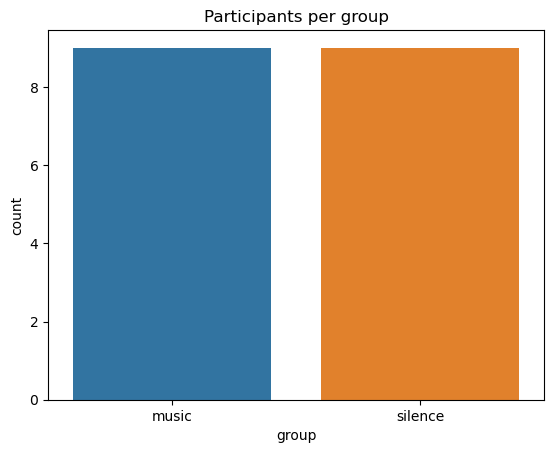

In [15]:
def get_participant_stats(data_by_participant_id):
    all_participant_ids_and_groups = pd.concat(
        [
            df[["participant_id", "group"]].drop_duplicates()
            for task, df in task_result_dfs.items()
        ],
        ignore_index=True,
    )
    return all_participant_ids_and_groups.drop_duplicates()


participants = get_participant_stats(task_result_dfs)
sns.countplot(x="group", data=participants)
plt.title("Participants per group")
plt.show()

In [16]:
def get_task_submission_stats(participant_data):
    stats = [{"group": d["group"], "task": d["task"], "submission": int(d["timestamp"])} for d in participant_data]
    df = pd.DataFrame(stats)
    df["submission"] = pd.to_datetime(df["submission"], unit="ms" )
    df.insert(0, "participant_id", participant_data[0]["participant_id"])
    return df


In [17]:
task_times = pd.concat(
    [get_task_submission_stats(d) for d in data_by_participant_id.values()],
    ignore_index=True,
).sort_values(by=["participant_id", "submission"])
task_times.head()


,participant_id,group,task,submission
0,13b948a8-5643-440a-871b-aca2b562b7dc,music,stroop,2023-01-07 14:48:33.558
1,13b948a8-5643-440a-871b-aca2b562b7dc,music,digit_span,2023-01-07 14:52:52.449
2,13b948a8-5643-440a-871b-aca2b562b7dc,music,symmetry_span,2023-01-07 15:01:20.164
27,21f08148-6cc6-4223-8364-24224a1f1945,silence,stroop,2023-01-06 14:19:41.709
28,21f08148-6cc6-4223-8364-24224a1f1945,silence,digit_span,2023-01-06 14:24:34.076


In [18]:
def get_time_spent_for_first_task(row):
  from datetime import datetime
  results = task_result_dfs[row.task].query(f"participant_id == '{row.participant_id}'")
  duration_finish = pd.Timedelta(np.timedelta64(results.time_elapsed.sort_values().iloc[-1], "ms"))
  return duration_finish

task_times.insert(3, "duration", task_times.apply(get_time_spent_for_first_task, axis=1))

In [19]:
task_times

,participant_id,group,task,duration,submission
0,13b948a8-5643-440a-871b-aca2b562b7dc,music,stroop,0 days 00:03:41.971000,2023-01-07 14:48:33.558
1,13b948a8-5643-440a-871b-aca2b562b7dc,music,digit_span,0 days 00:04:06.952000,2023-01-07 14:52:52.449
2,13b948a8-5643-440a-871b-aca2b562b7dc,music,symmetry_span,0 days 00:08:22.917000,2023-01-07 15:01:20.164
27,21f08148-6cc6-4223-8364-24224a1f1945,silence,stroop,0 days 00:07:07.124000,2023-01-06 14:19:41.709
28,21f08148-6cc6-4223-8364-24224a1f1945,silence,digit_span,0 days 00:04:46.751000,2023-01-06 14:24:34.076
29,21f08148-6cc6-4223-8364-24224a1f1945,silence,symmetry_span,0 days 00:09:16.463000,2023-01-06 14:33:58.409
3,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music,stroop,0 days 00:03:46.488000,2023-01-06 18:24:36.671
4,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music,digit_span,0 days 00:03:40.828000,2023-01-06 18:28:21.436
5,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music,symmetry_span,0 days 00:04:15.954000,2023-01-06 18:32:41.619
30,3cceca25-8b8b-49ad-b24d-03ed68601439,silence,stroop,0 days 00:04:41.275000,2023-01-06 14:58:27.358


In [20]:
task_times["duration_min" ] = task_times["duration"].dt.total_seconds()/60

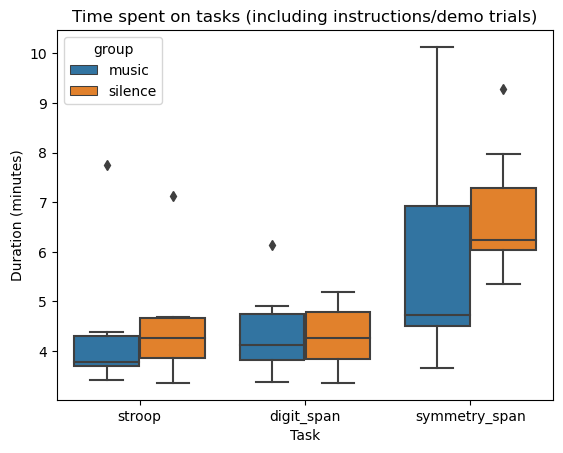

In [21]:
sns.boxplot(x="task", y="duration_min", hue="group", data=task_times)
plt.title("Time spent on tasks (including instructions/demo trials)")
plt.xlabel("Task")
plt.ylabel("Duration (minutes)")
plt.show()

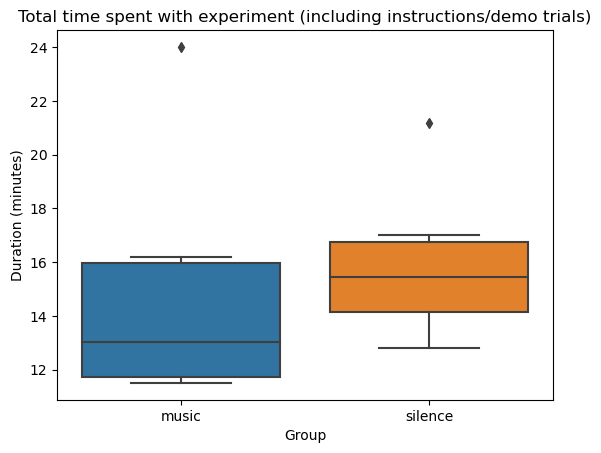

In [22]:
sns.boxplot(y="duration_min", x="group", data=task_times.groupby(["group", "participant_id"], as_index=False).sum())
plt.title("Total time spent with experiment (including instructions/demo trials)")
plt.xlabel("Group")
plt.ylabel("Duration (minutes)")
plt.show()

## Analyze Stroop task results

In [23]:
stroop_results = task_result_dfs["stroop"].copy()
stroop_results.head()

,rt,stimulus,key_press,Congruency,letter,type,trial_type,trial_index,time_elapsed,internal_node_id,correct,participant_id,group
0,788.7,"<table border=""0"" width=""600""><tr height=""300""...",78,Con,n,test trial,html-keyboard-response,53,78253,0.0-6.0-1.0,True,13b948a8-5643-440a-871b-aca2b562b7dc,music
1,498.0,"<table border=""0"" width=""600""><tr height=""300""...",86,Con,v,test trial,html-keyboard-response,55,79253,0.0-6.0-1.1,True,13b948a8-5643-440a-871b-aca2b562b7dc,music
2,476.7,"<table border=""0"" width=""600""><tr height=""300""...",66,Incon,b,test trial,html-keyboard-response,57,80989,0.0-6.0-1.2,True,13b948a8-5643-440a-871b-aca2b562b7dc,music
3,459.6,"<table border=""0"" width=""600""><tr height=""300""...",77,Incon,m,test trial,html-keyboard-response,59,82707,0.0-6.0-1.3,True,13b948a8-5643-440a-871b-aca2b562b7dc,music
4,444.2,"<table border=""0"" width=""600""><tr height=""300""...",86,Incon,v,test trial,html-keyboard-response,61,85156,0.0-6.0-1.4,True,13b948a8-5643-440a-871b-aca2b562b7dc,music


In [24]:
stroop_results.type.value_counts()

test trial    1440
Name: type, dtype: int64

In [25]:
stroop_results.trial_type.value_counts()

html-keyboard-response    1440
Name: trial_type, dtype: int64

It's safe to remove the type and trial_type information. The internal_node_id column is also irrelevant.

In [26]:
stroop_results = stroop_results.drop(columns=["type", "trial_type", "internal_node_id"])


### Making sense of stimulus and letter columns

In [27]:
def extract_rgb(stimulus):
    return [
        int(color_str)
        for color_str in stimulus.split("rgb(")[1].split(")")[0].split(",")
    ]

stroop_results.stimulus.apply(extract_rgb).value_counts()

[0, 255, 0]      360
[255, 0, 0]      360
[255, 255, 0]    360
[0, 0, 255]      360
Name: stimulus, dtype: int64

In [28]:
def get_color(rgb_vals):
    if rgb_vals[0] == 255 and rgb_vals[1] == 0 and rgb_vals[2] == 0:
        return "red"
    elif rgb_vals[0] == 255 and rgb_vals[1] == 255 and rgb_vals[2] == 0:
        return "yellow"
    elif rgb_vals[0] == 0 and rgb_vals[1] == 255 and rgb_vals[2] == 0:
        return "green"
    elif rgb_vals[0] == 0 and rgb_vals[1] == 0 and rgb_vals[2] == 255:
        return "blue"
    else:
        return "unknown"

stroop_results.stimulus.apply(extract_rgb).apply(get_color).value_counts()

green     360
red       360
yellow    360
blue      360
Name: stimulus, dtype: int64

In [29]:
def letter_to_color(key):
    if key == "v":
        return "red"
    elif key == "b":
        return "yellow"
    elif key == "n":
        return "green"
    elif key == "m":
        return "blue"
    else:
        return "unknown"
        
stroop_results.letter.apply(letter_to_color).value_counts()

green     360
red       360
yellow    360
blue      360
Name: letter, dtype: int64

The key column contains the JavaScript keycodes that were pressed by the users (for a demo check [this](https://www.toptal.com/developers/keycode]) out).

In [30]:
def key_to_color(key):
    if key == 86:
        return "red"
    elif key == 66:
        return "yellow"
    elif key == 78:
        return "green"
    elif key == 77:
        return "blue"
    else:
        return "unknown"

stroop_results.key_press.apply(key_to_color).value_counts()

yellow    362
green     360
red       360
blue      358
Name: key_press, dtype: int64

In [31]:
def extract_true_and_response(row):
    rgb_vals = extract_rgb(row.stimulus)
    true_color = get_color(rgb_vals)
    key = row.key_press
    response = key_to_color(key)
    return pd.Series([true_color, response])


stroop_results[["true_color", "response"]] = stroop_results.apply(
    extract_true_and_response, axis=1, result_type="expand"
).rename(columns={0: "true_color", 1: "response"})
stroop_results.drop(columns=["stimulus", "letter"], inplace=True)
stroop_results

,rt,key_press,Congruency,trial_index,time_elapsed,correct,participant_id,group,true_color,response
0,788.7,78,Con,53,78253,True,13b948a8-5643-440a-871b-aca2b562b7dc,music,green,green
1,498.0,86,Con,55,79253,True,13b948a8-5643-440a-871b-aca2b562b7dc,music,red,red
2,476.7,66,Incon,57,80989,True,13b948a8-5643-440a-871b-aca2b562b7dc,music,yellow,yellow
3,459.6,77,Incon,59,82707,True,13b948a8-5643-440a-871b-aca2b562b7dc,music,blue,blue
4,444.2,86,Incon,61,85156,True,13b948a8-5643-440a-871b-aca2b562b7dc,music,red,red
...,...,...,...,...,...,...,...,...,...,...
75,938.0,66,Con,203,249473,True,f7cee892-7665-4c02-8b0e-005e0c255378,silence,yellow,yellow
76,651.0,78,Incon,205,250379,True,f7cee892-7665-4c02-8b0e-005e0c255378,silence,green,green
77,549.0,77,Con,207,252434,True,f7cee892-7665-4c02-8b0e-005e0c255378,silence,blue,blue
78,525.0,86,Con,209,254715,True,f7cee892-7665-4c02-8b0e-005e0c255378,silence,red,red


In [32]:
stroop_results.loc[stroop_results.true_color != stroop_results.response, "correct"].sum()

0

In [33]:
stroop_results.loc[stroop_results.true_color == stroop_results.response, "correct"].sum()

1397

In [34]:
stroop_results.correct.sum()

1397

In [35]:
stroop_results.groupby(["group", "participant_id"])[["rt", "correct"]].mean()

rt  correct
group   participant_id                                           
music   13b948a8-5643-440a-871b-aca2b562b7dc   674.66000   0.9750
        31762cb9-3f06-46f8-a6aa-0cb7e725cba9   829.75000   0.9875
        7f0450b7-99f7-47e9-8895-9011a537396a  1414.62625   0.9500
        8184eb4a-6f2a-435f-99e0-de643d884b97   687.65000   0.9750
        88b5c856-49c7-4113-873d-671c29bff218   873.21375   0.8875
        9547b8d4-5448-4b85-b0da-2c8461c00bcb   716.91000   1.0000
        a4948d9f-faa2-415f-a376-4c3dea9296ce   688.37750   0.9625
        a700e9ac-d53c-4dcd-8ea4-eb6bf58ad454   898.62500   0.9875
        b8143791-ab78-4c4b-bc14-ab3f16549bb5   792.51000   0.9625
silence 21f08148-6cc6-4223-8364-24224a1f1945  1381.95375   1.0000
        3cceca25-8b8b-49ad-b24d-03ed68601439   800.75000   0.9500
        62c8661e-b8e2-48a1-b1a3-4221427237a6  1032.23000   0.9750
        7c732653-87e7-4c4f-8fe7-9fa40975315d   644.61250   0.9500
        97b70c25-77c5-47b7-8a2c-eb59bd2842cc  1016.08750   1.0000
        a0e19014-0ebd-4783-8032-cea5677e4a11   921.95375   0.9875
        b7f6b744-ff66-42a3-b892-4ba6777a970a   686.91000   0.9875
        f79822ed-ce4d-43b8-8a67-6160685e6d53   613.35875   0.9250
        f7cee892-7665-4c02-8b0e-005e0c255378   642.90000   1.0000

In [36]:
stroop_results.groupby(["group"]).rt.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
music,720.0,841.813611,339.710570,347.7,635.00,754.25,978.325,3659.5
silence,720.0,860.084028,411.605549,309.0,606.65,746.95,956.275,4018.0


<AxesSubplot:xlabel='group', ylabel='rt'>

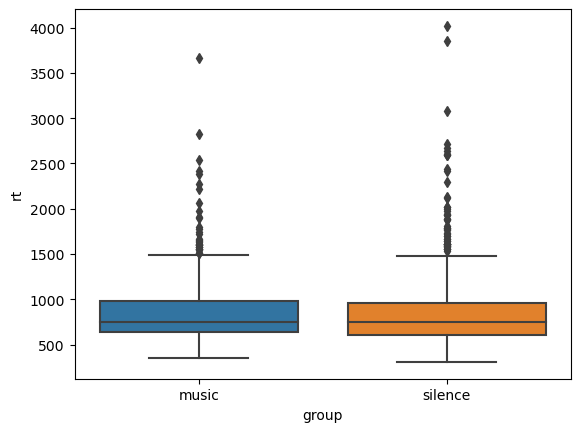

In [37]:
sns.boxplot(x="group", y="rt", data=stroop_results)

In [38]:
stroop_results.groupby("group").correct.sum() / stroop_results.groupby("group").correct.count()

group
music      0.965278
silence    0.975000
Name: correct, dtype: float64

## Analyzing digit span task results

In [39]:
digit_span_results = task_result_dfs["digit_span"].copy()
digit_span_results

,rt,recall,stimuli,accuracy,trial_type,trial_index,time_elapsed,internal_node_id,participant_id,group
0,6383,"3,7,8","3,7,8",1,digit-span-recall,5,33133,0.0-2.0-1.0,13b948a8-5643-440a-871b-aca2b562b7dc,music
1,4072,"8,9,7,0","8,9,7,0",1,digit-span-recall,11,42243,0.0-2.0-1.1,13b948a8-5643-440a-871b-aca2b562b7dc,music
2,5045,"7,9,1,4,0","7,9,1,4,0",1,digit-span-recall,18,53324,0.0-2.0-1.2,13b948a8-5643-440a-871b-aca2b562b7dc,music
3,2730,"1,3,5","1,3,5",1,digit-span-recall,24,64158,0.0-4.0-1.0,13b948a8-5643-440a-871b-aca2b562b7dc,music
4,3481,"4,2,9,3","4,2,9,3",1,digit-span-recall,30,72665,0.0-4.0-1.1,13b948a8-5643-440a-871b-aca2b562b7dc,music
...,...,...,...,...,...,...,...,...,...,...
12,11484,"6,5,2,8,9,0,3","6,5,2,8,9,0,3",1,digit-span-recall,103,232548,0.0-4.0-1.9,f7cee892-7665-4c02-8b0e-005e0c255378,silence
13,16100,"6,5,3,9,4,8,2","5,9,3,2,6,4,8,0",0,digit-span-recall,113,257675,0.0-4.0-1.10,f7cee892-7665-4c02-8b0e-005e0c255378,silence
14,9110,"0,7,4,6,9,5,8,1","0,7,4,6,9,5,1,8",0,digit-span-recall,123,275813,0.0-4.0-1.11,f7cee892-7665-4c02-8b0e-005e0c255378,silence
15,6025,"5,8,6,4,3,1,9","5,8,6,4,3,1,9",1,digit-span-recall,132,289864,0.0-4.0-1.12,f7cee892-7665-4c02-8b0e-005e0c255378,silence


In [40]:
digit_span_results.accuracy.value_counts()

1    182
0    124
Name: accuracy, dtype: int64

In [41]:
digit_span_results["correct"] = digit_span_results.accuracy == 1
digit_span_results.drop(columns=["accuracy", "internal_node_id"], inplace=True)

In [42]:
digit_span_results.correct.sum() / len(digit_span_results)

0.5947712418300654

In [43]:
digit_span_results.groupby(["group", "participant_id"])[["rt", "correct"]].mean()

rt   correct
group   participant_id                                              
music   13b948a8-5643-440a-871b-aca2b562b7dc   5899.529412  0.588235
        31762cb9-3f06-46f8-a6aa-0cb7e725cba9   4292.000000  0.647059
        7f0450b7-99f7-47e9-8895-9011a537396a  12258.058824  0.529412
        8184eb4a-6f2a-435f-99e0-de643d884b97   5197.764706  0.647059
        88b5c856-49c7-4113-873d-671c29bff218   5627.117647  0.470588
        9547b8d4-5448-4b85-b0da-2c8461c00bcb   4353.529412  0.647059
        a4948d9f-faa2-415f-a376-4c3dea9296ce   8219.588235  0.705882
        a700e9ac-d53c-4dcd-8ea4-eb6bf58ad454   7235.058824  0.529412
        b8143791-ab78-4c4b-bc14-ab3f16549bb5   5286.294118  0.647059
silence 21f08148-6cc6-4223-8364-24224a1f1945   7106.352941  0.647059
        3cceca25-8b8b-49ad-b24d-03ed68601439   9103.941176  0.588235
        62c8661e-b8e2-48a1-b1a3-4221427237a6   6843.000000  0.470588
        7c732653-87e7-4c4f-8fe7-9fa40975315d   6503.176471  0.647059
        97b70c25-77c5-47b7-8a2c-eb59bd2842cc   5633.529412  0.529412
        a0e19014-0ebd-4783-8032-cea5677e4a11   7571.882353  0.588235
        b7f6b744-ff66-42a3-b892-4ba6777a970a   4281.882353  0.588235
        f79822ed-ce4d-43b8-8a67-6160685e6d53   5091.117647  0.647059
        f7cee892-7665-4c02-8b0e-005e0c255378   8683.882353  0.588235

In [44]:
digit_span_results.groupby(["group"]).rt.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
music,153.0,6485.437908,7444.406586,696.0,3939.0,5521.0,7687.0,91447.0
silence,153.0,6757.640523,3036.644919,1856.0,4467.0,6261.0,8526.0,16100.0


In [45]:
digit_span_results.groupby(["group"]).correct.sum() / digit_span_results.groupby(["group"]).correct.count()

group
music      0.601307
silence    0.588235
Name: correct, dtype: float64

<AxesSubplot:xlabel='group', ylabel='rt'>

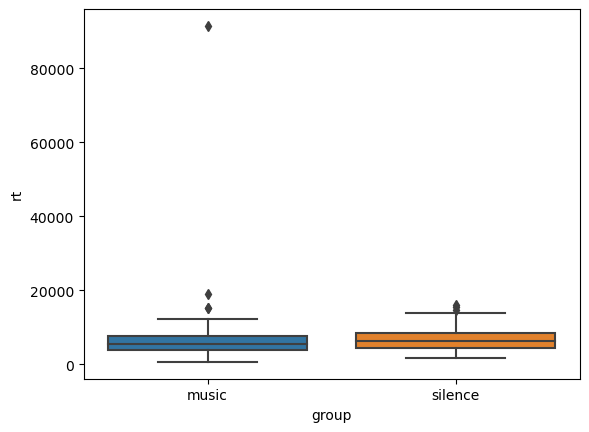

In [46]:
sns.boxplot(x="group", y="rt", data=digit_span_results)

### Analyze results by sequence length

TODO

## Analyzing symmetry span results

In [47]:
symmetry_span_results = task_result_dfs["symmetry_span"].copy()
symmetry_span_results.set_index("participant_id")

,rt,recall,stimuli,accuracy,set_size,trial_type,trial_index,time_elapsed,internal_node_id,group
participant_id,,,,,,,,,,
13b948a8-5643-440a-871b-aca2b562b7dc,4390.0,"0,11,13","0,0,2,3,3,1",3.0,3.0,spatial-span-recall,8,226751,0.0-2.0-1.0,music
13b948a8-5643-440a-871b-aca2b562b7dc,3713.0,"5,2,12,11","1,1,0,2,3,0,1,3",3.0,4.0,spatial-span-recall,18,236412,0.0-2.0-1.1,music
13b948a8-5643-440a-871b-aca2b562b7dc,2402.0,"6,5,8,9","1,2,1,1,2,0,2,1",4.0,4.0,spatial-span-recall,28,243831,0.0-2.0-1.2,music
13b948a8-5643-440a-871b-aca2b562b7dc,3040.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,31,262751,0.0-4.0-0.0,music
13b948a8-5643-440a-871b-aca2b562b7dc,1159.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,33,265111,0.0-4.0-0.1,music
...,...,...,...,...,...,...,...,...,...,...
f7cee892-7665-4c02-8b0e-005e0c255378,1221.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,192,350272,0.0-8.0-0.8-1.32,silence
f7cee892-7665-4c02-8b0e-005e0c255378,807.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,195,352248,0.0-8.0-0.8-1.33,silence
f7cee892-7665-4c02-8b0e-005e0c255378,806.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,198,354214,0.0-8.0-0.8-1.34,silence


### Identifying and removing demo trial results

Unfortunately, there was a mistake in the symmetry span task setup: the CSV file doesn't clearly indicate what trials are actually only demo trials and which ones are part of the "real task" (after the demo). So, we need to compare the results for one arbitrary participant with the results for a local demo run we did without the `test_procedure` part of the symmetry span task. 

In [48]:
pd.set_option('display.max_rows', 500)
symmetry_span_results[symmetry_span_results.participant_id == "31762cb9-3f06-46f8-a6aa-0cb7e725cba9"]

,rt,recall,stimuli,accuracy,set_size,trial_type,trial_index,time_elapsed,internal_node_id,participant_id,group
0,4778.0,"10,3,6","2,2,0,3,1,2",3.0,3.0,spatial-span-recall,8,35011,0.0-2.0-1.0,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
1,2157.0,"0,7,14,5","0,0,1,3,3,2,1,1",4.0,4.0,spatial-span-recall,18,42787,0.0-2.0-1.1,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
2,2197.0,"3,0,8,11","0,3,0,0,2,0,2,3",4.0,4.0,spatial-span-recall,28,50211,0.0-2.0-1.2,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
3,2526.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,31,66667,0.0-4.0-0.0,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
4,949.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,33,68931,0.0-4.0-0.1,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
5,769.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,35,71051,0.0-4.0-0.2,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
6,1050.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,37,73419,0.0-4.0-0.3,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
7,1082.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,39,75827,0.0-4.0-0.4,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
8,2360.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,43,85507,0.0-6.0-0.0-1.0,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music
9,1456.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,46,88395,0.0-6.0-0.0-1.1,31762cb9-3f06-46f8-a6aa-0cb7e725cba9,music


In [49]:
pd.reset_option('display.max_rows')

In [50]:
demo_run = pd.read_csv("symmetry_span_before_test_procedure.csv")
demo_run

,rt,recall,stimuli,accuracy,set_size,trial_type,trial_index,time_elapsed,internal_node_id
0,2722,"7,6,0","1,3,1,2,0,0",3,3.0,spatial-span-recall,8,13685,0.0-2.0-1.0
1,2495,"1,2,0,12","0,1,0,2,0,0,3,0",4,4.0,spatial-span-recall,18,21048,0.0-2.0-1.1
2,3119,"3,14,12,13","0,3,3,2,3,0,3,1",4,4.0,spatial-span-recall,28,29162,0.0-2.0-1.2
3,1333,NaN,NaN,1,NaN,symmetry-judgement-task,31,32508,0.0-4.0-0.0
4,864,NaN,NaN,1,NaN,symmetry-judgement-task,33,34511,0.0-4.0-0.1
5,667,NaN,NaN,1,NaN,symmetry-judgement-task,35,36340,0.0-4.0-0.2
6,670,NaN,NaN,0,NaN,symmetry-judgement-task,37,38168,0.0-4.0-0.3
7,775,NaN,NaN,1,NaN,symmetry-judgement-task,39,40086,0.0-4.0-0.4
8,2081,NaN,NaN,1,NaN,symmetry-judgement-task,43,47437,0.0-6.0-0.0-1.0
9,836,NaN,NaN,1,NaN,symmetry-judgement-task,46,49445,0.0-6.0-0.0-1.1


We see that the last "demo trial index" is 76, so we should remove all the entries in the results where the value of `trial_index` is <= 76. Again, the `internal_node_id` column is not relevant.

In [51]:
symmetry_span_results = symmetry_span_results[symmetry_span_results.trial_index > 76].reset_index(drop=True).drop(columns=["internal_node_id"])
symmetry_span_results

,rt,recall,stimuli,accuracy,set_size,trial_type,trial_index,time_elapsed,participant_id,group
0,1467.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,80,369208,13b948a8-5643-440a-871b-aca2b562b7dc,music
1,2469.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,83,372856,13b948a8-5643-440a-871b-aca2b562b7dc,music
2,1056.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,86,375123,13b948a8-5643-440a-871b-aca2b562b7dc,music
3,1586.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,89,377978,13b948a8-5643-440a-871b-aca2b562b7dc,music
4,1851.0,"5,6,10,8","1,2,1,1,2,2,2,0",2.0,4.0,spatial-span-recall,91,379833,13b948a8-5643-440a-871b-aca2b562b7dc,music
...,...,...,...,...,...,...,...,...,...,...
805,1221.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,192,350272,f7cee892-7665-4c02-8b0e-005e0c255378,silence
806,807.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,195,352248,f7cee892-7665-4c02-8b0e-005e0c255378,silence
807,806.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,198,354214,f7cee892-7665-4c02-8b0e-005e0c255378,silence
808,1073.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,201,356441,f7cee892-7665-4c02-8b0e-005e0c255378,silence


We notice that the `recall` column and the `stimuli` columns don't match in terms of format: the stimuli were always presented in a 4 x 4 grid. The `recall` column contains the grid number the participant selected if we counted them from left to right, top to bottom, while the `stimuli` column contains pairs of `(row_index, column_index)` (both zero-based).

Also, it looks like the `stimuli` column only contains values for the `spatial-span-recall` task type.

In [52]:
symmetry_span_results.stimuli.notna().sum()

162

In [53]:
symmetry_span_results[symmetry_span_results.trial_type == "spatial-span-recall"].shape[0]

162

In [54]:
def reformat_recall_and_stimuli(row):
  recall = row.recall
  if type(recall) != str:
    # recall is NaN
    return float('nan'), float('nan')

  recall = [int(i) for i in recall.split(",")]
  stimuli = row.stimuli
  stimuli = stimuli.split(",")
  row_idxs = [int(idx) for idx in stimuli[::2]]
  col_idxs = [int(idx) for idx in stimuli[1::2]]
  stimuli = [4*row_idx + col_idx for row_idx, col_idx in zip(row_idxs, col_idxs)]
  return stimuli, recall

symmetry_span_results[["stimuli", "recall"]] = symmetry_span_results.apply(reformat_recall_and_stimuli, axis=1, result_type="expand")
symmetry_span_results

,rt,recall,stimuli,accuracy,set_size,trial_type,trial_index,time_elapsed,participant_id,group
0,1467.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,80,369208,13b948a8-5643-440a-871b-aca2b562b7dc,music
1,2469.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,83,372856,13b948a8-5643-440a-871b-aca2b562b7dc,music
2,1056.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,86,375123,13b948a8-5643-440a-871b-aca2b562b7dc,music
3,1586.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,89,377978,13b948a8-5643-440a-871b-aca2b562b7dc,music
4,1851.0,"[5, 6, 10, 8]","[6, 5, 10, 8]",2.0,4.0,spatial-span-recall,91,379833,13b948a8-5643-440a-871b-aca2b562b7dc,music
...,...,...,...,...,...,...,...,...,...,...
805,1221.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,192,350272,f7cee892-7665-4c02-8b0e-005e0c255378,silence
806,807.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,195,352248,f7cee892-7665-4c02-8b0e-005e0c255378,silence
807,806.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,198,354214,f7cee892-7665-4c02-8b0e-005e0c255378,silence
808,1073.0,NaN,NaN,1.0,NaN,symmetry-judgement-task,201,356441,f7cee892-7665-4c02-8b0e-005e0c255378,silence


The DataFrame contents don't reflect the fact that the symmetry judgement tasks were shown after each cell of the spatial span recall sequence. So, the symmetry judgement tasks that follow each recall task were actually "intertwined" with it. Therefore, we can fill the NaN values in `set_size` for all symmetry-judgement-tasks with the value that follows it. This can be achieved by using `fillna(method="backfill")` on the column.

In [55]:
symmetry_span_results.set_size = symmetry_span_results.set_size.fillna(method="backfill")
symmetry_span_results

,rt,recall,stimuli,accuracy,set_size,trial_type,trial_index,time_elapsed,participant_id,group
0,1467.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,80,369208,13b948a8-5643-440a-871b-aca2b562b7dc,music
1,2469.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,83,372856,13b948a8-5643-440a-871b-aca2b562b7dc,music
2,1056.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,86,375123,13b948a8-5643-440a-871b-aca2b562b7dc,music
3,1586.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,89,377978,13b948a8-5643-440a-871b-aca2b562b7dc,music
4,1851.0,"[5, 6, 10, 8]","[6, 5, 10, 8]",2.0,4.0,spatial-span-recall,91,379833,13b948a8-5643-440a-871b-aca2b562b7dc,music
...,...,...,...,...,...,...,...,...,...,...
805,1221.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,192,350272,f7cee892-7665-4c02-8b0e-005e0c255378,silence
806,807.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,195,352248,f7cee892-7665-4c02-8b0e-005e0c255378,silence
807,806.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,198,354214,f7cee892-7665-4c02-8b0e-005e0c255378,silence
808,1073.0,NaN,NaN,1.0,4.0,symmetry-judgement-task,201,356441,f7cee892-7665-4c02-8b0e-005e0c255378,silence


It probably makes sense to split the data for the two different types of trials into separate DataFrames.

In [56]:
symmetry_judgments = (
    symmetry_span_results[symmetry_span_results.trial_type == "symmetry-judgement-task"]
    .drop(columns=["trial_type", "stimuli", "recall"])
    .rename(columns={"accuracy": "correct"})
)
symmetry_judgments


,rt,correct,set_size,trial_index,time_elapsed,participant_id,group
0,1467.0,1.0,4.0,80,369208,13b948a8-5643-440a-871b-aca2b562b7dc,music
1,2469.0,1.0,4.0,83,372856,13b948a8-5643-440a-871b-aca2b562b7dc,music
2,1056.0,1.0,4.0,86,375123,13b948a8-5643-440a-871b-aca2b562b7dc,music
3,1586.0,1.0,4.0,89,377978,13b948a8-5643-440a-871b-aca2b562b7dc,music
5,2375.0,1.0,5.0,94,386840,13b948a8-5643-440a-871b-aca2b562b7dc,music
...,...,...,...,...,...,...,...
803,1428.0,1.0,5.0,187,340074,f7cee892-7665-4c02-8b0e-005e0c255378,silence
805,1221.0,1.0,4.0,192,350272,f7cee892-7665-4c02-8b0e-005e0c255378,silence
806,807.0,1.0,4.0,195,352248,f7cee892-7665-4c02-8b0e-005e0c255378,silence
807,806.0,1.0,4.0,198,354214,f7cee892-7665-4c02-8b0e-005e0c255378,silence


In [57]:
symmetry_judgments[symmetry_judgments.rt.isna()]

,rt,correct,set_size,trial_index,time_elapsed,participant_id,group
610,NaN,NaN,3.0,150,349059,97b70c25-77c5-47b7-8a2c-eb59bd2842cc,silence


One row's Response Time is NaN, but why?

I did a test run with only the `test_procedure` part of the spatial span task where I deliberately waited for the symmetry judgements to time out. Let's look at the results: 

In [58]:
pd.read_csv("sym_span_test_only_timeout_first_symmetry_tasks.csv").head(10)

,rt,accuracy,trial_type,trial_index,time_elapsed,internal_node_id,recall,stimuli,set_size
0,NaN,NaN,symmetry-judgement-task,2,10887,0.0-1.0-0.0-1.0,NaN,NaN,NaN
1,NaN,NaN,symmetry-judgement-task,5,18006,0.0-1.0-0.0-1.1,NaN,NaN,NaN
2,NaN,NaN,symmetry-judgement-task,8,25110,0.0-1.0-0.0-1.2,NaN,NaN,NaN
3,8577.0,0.0,spatial-span-recall,10,33704,0.0-1.0-1.0,"6,5,9,10","0,3,1,2,1,3",3.0
4,NaN,NaN,symmetry-judgement-task,13,41886,0.0-1.0-0.1-1.3,NaN,NaN,NaN
5,2985.0,1.0,symmetry-judgement-task,16,45974,0.0-1.0-0.1-1.4,NaN,NaN,NaN
6,1326.0,0.0,symmetry-judgement-task,19,48423,0.0-1.0-0.1-1.5,NaN,NaN,NaN
7,529.0,0.0,symmetry-judgement-task,22,50067,0.0-1.0-0.1-1.6,NaN,NaN,NaN
8,2050.0,0.0,spatial-span-recall,24,52135,0.0-1.0-1.1,9,"3,0,1,3,0,1,3,3",4.0
9,569.0,1.0,symmetry-judgement-task,27,54620,0.0-1.0-0.2-1.7,NaN,NaN,NaN


And we see that this is the reason for the missing value! How should we treat it for data analysis purposes? What value should be imputed?

Maybe a boxplot of the response times will help us:

<AxesSubplot:xlabel='group', ylabel='rt'>

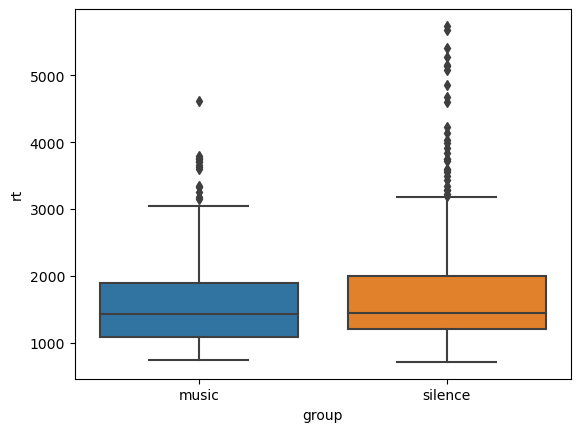

In [59]:
sns.boxplot(data=symmetry_judgments, x="group", y="rt")

In [60]:
symmetry_judgments.correct.sum() / len(symmetry_judgments)

0.9845679012345679

In [61]:
symmetry_judgments.groupby(["group", "participant_id"])[["rt", "correct"]].mean()

rt   correct
group   participant_id                                             
music   13b948a8-5643-440a-871b-aca2b562b7dc  1409.777778  1.000000
        31762cb9-3f06-46f8-a6aa-0cb7e725cba9  1133.777778  1.000000
        7f0450b7-99f7-47e9-8895-9011a537396a  2453.277778  0.916667
        8184eb4a-6f2a-435f-99e0-de643d884b97  1093.472222  1.000000
        88b5c856-49c7-4113-873d-671c29bff218  1717.722222  1.000000
        9547b8d4-5448-4b85-b0da-2c8461c00bcb  1545.027778  1.000000
        a4948d9f-faa2-415f-a376-4c3dea9296ce  1196.361111  1.000000
        a700e9ac-d53c-4dcd-8ea4-eb6bf58ad454  2108.083333  1.000000
        b8143791-ab78-4c4b-bc14-ab3f16549bb5  1873.555556  0.972222
silence 21f08148-6cc6-4223-8364-24224a1f1945  3618.861111  0.944444
        3cceca25-8b8b-49ad-b24d-03ed68601439  1991.111111  0.944444
        62c8661e-b8e2-48a1-b1a3-4221427237a6  1503.472222  1.000000
        7c732653-87e7-4c4f-8fe7-9fa40975315d  1460.027778  0.972222
        97b70c25-77c5-47b7-8a2c-eb59bd2842cc  2235.342857  1.000000
        a0e19014-0ebd-4783-8032-cea5677e4a11  1494.611111  1.000000
        b7f6b744-ff66-42a3-b892-4ba6777a970a  1184.833333  1.000000
        f79822ed-ce4d-43b8-8a67-6160685e6d53  1132.333333  1.000000
        f7cee892-7665-4c02-8b0e-005e0c255378  1245.472222  1.000000

In [62]:
symmetry_judgments.groupby(["group"])[["rt", "correct"]].mean()

,rt,correct
group,,
music,1614.561728,0.987654
silence,1761.433437,0.984520


In [63]:
symmetry_judgments.groupby(["group"])[["rt"]].describe()

rt                                                           \
         count         mean         std    min      25%     50%     75%   
group                                                                     
music    324.0  1614.561728  704.456807  738.0  1080.25  1435.0  1897.5   
silence  323.0  1761.433437  945.561704  710.0  1200.00  1444.0  1998.5   

                 
            max  
group            
music    4615.0  
silence  5742.0

In [64]:
spatial_recall_results = (
    symmetry_span_results[symmetry_span_results.trial_type == "spatial-span-recall"]
    .drop(columns=["trial_type"])
    .rename(columns={"accuracy": "correct_cells"})
)
spatial_recall_results.insert(4, "all_correct", spatial_recall_results.correct_cells == spatial_recall_results.set_size)
spatial_recall_results


,rt,recall,stimuli,correct_cells,all_correct,set_size,trial_index,time_elapsed,participant_id,group
4,1851.0,"[5, 6, 10, 8]","[6, 5, 10, 8]",2.0,False,4.0,91,379833,13b948a8-5643-440a-871b-aca2b562b7dc,music
10,3292.0,"[6, 14, 0, 9, 2]","[6, 14, 0, 10, 2]",4.0,False,5.0,108,400090,13b948a8-5643-440a-871b-aca2b562b7dc,music
15,3319.0,"[14, 9, 1, 13]","[14, 9, 1, 13]",4.0,True,4.0,122,416078,13b948a8-5643-440a-871b-aca2b562b7dc,music
21,2746.0,"[5, 2, 15, 10, 12]","[5, 2, 15, 10, 12]",5.0,True,5.0,139,431813,13b948a8-5643-440a-871b-aca2b562b7dc,music
25,3679.0,"[3, 15, 9]","[3, 15, 9]",3.0,True,3.0,150,445916,13b948a8-5643-440a-871b-aca2b562b7dc,music
...,...,...,...,...,...,...,...,...,...,...
786,3172.0,"[9, 10, 14]","[9, 10, 14]",3.0,True,3.0,138,277884,f7cee892-7665-4c02-8b0e-005e0c255378,silence
792,6803.0,"[6, 2, 1, 9, 3]","[6, 2, 1, 13, 3]",4.0,False,5.0,155,298821,f7cee892-7665-4c02-8b0e-005e0c255378,silence
798,12374.0,"[11, 9, 6, 14, 7]","[11, 9, 6, 14, 7]",5.0,True,5.0,172,326710,f7cee892-7665-4c02-8b0e-005e0c255378,silence
804,6130.0,"[2, 1, 3, 12, 11]","[2, 1, 3, 12, 11]",5.0,True,5.0,189,346219,f7cee892-7665-4c02-8b0e-005e0c255378,silence
